![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## 1. Get the Data

You can find the data at this Google Drive URL (NPZ format)

https://drive.google.com/file/d/1-OplAg9THXuzKC_oYAiB4wdBmCTdiy4z/view?usp=sharing <br>
https://drive.google.com/file/d/1-Svi93L-C7qAq2oJmtajfCJDjGdJTIaE/view?usp=sharing <br>
https://drive.google.com/file/d/1-Dpozh1KCEvuCYgYuaf98-PzHhHTo3F_/view?usp=sharing <br>


If working at colab, mount Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Libraries

To begin, let's load those libraries that we need

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

## 3. Defining some constants

In [3]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# We define the path where you have the NPZ files
path = "drive/MyDrive/"

## 4. We prepare the training data

We will load them in the NPZ format that we discussed in the last class

In [31]:
dict_npz = np.load(path+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(path+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(path+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [32]:
print("Shape X train:", x_train_scaled.shape)
print("Shape Y train:", y_train_img.shape)

print("Shape X test:", x_test_scaled.shape)
print("Shape Y test:", y_test_img.shape)

print("Shape X val:", x_val_scaled.shape)
print("Shape Y val:", y_val_img.shape)



Shape X train: (5000, 150, 150, 3)
Shape Y train: (5000,)
Shape X test: (1000, 150, 150, 3)
Shape Y test: (1000,)
Shape X val: (1000, 150, 150, 3)
Shape Y val: (1000,)


## 5. Explore the data

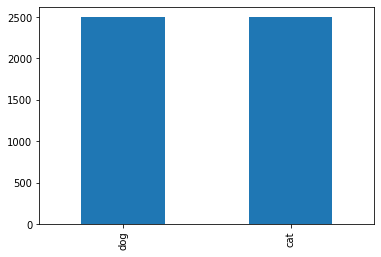

In [33]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

As we can see we have 2500 examples of each class ... a little to be a neural network for computer vision ... you will see ...

## 6. Lets see an image

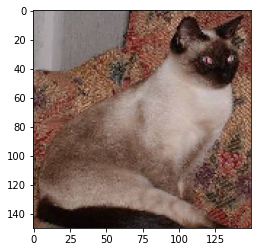

In [34]:
sample = random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Let's stack blocks to make the model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

### 7.1 Let's get our feature extractor VGG16

In [35]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [37]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [38]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [39]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7efeeb448c90>,input_2,True
1,<keras.layers.convolutional.Conv2D object at 0x7efeeb4ca690>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7effe57786d0>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7efeeb417fd0>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7effe024cfd0>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7effe52e7950>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7effe52e7810>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7effe53064d0>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7efeeb498290>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7efeeb3a65d0>,block3_conv3,True


In [40]:
vgg_model.trainable

True

In [41]:
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

In [42]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7efeeb448c90>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7efeeb4ca690>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7effe57786d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7efeeb417fd0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7effe024cfd0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7effe52e7950>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7effe52e7810>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7effe53064d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7efeeb498290>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7efeeb3a65d0>,block3_conv3,False


### Let's make conv blocks 4 and 5 trainiable

In [43]:
vgg_model.trainable = True

trainable = False
for layer in vgg_model.layers:
  if layer.name=='block4_conv1':
    trainable = True

  layer.trainable = trainable


In [44]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7efeeb448c90>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7efeeb4ca690>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7effe57786d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7efeeb417fd0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7effe024cfd0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7effe52e7950>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7effe52e7810>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7effe53064d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7efeeb498290>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7efeeb3a65d0>,block3_conv3,False


### 7.3 Build classifier network

In [45]:
input_shape = vgg_model.output_shape[1]
print(input_shape)

8192


In [46]:
model = ks.Sequential()

model.add(vgg_model)
model.add(ks.layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 of output as the target is binary (0 or 1)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 17,437,185


## 8. Let's compile the model

In [47]:
from tensorflow.keras.optimizers import Adam, SGD

In [48]:
new_adam = Adam(learning_rate=2e-5) # Adam by default is lr = 0.01
new_sgd = SGD(learning_rate=2e-5, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=new_sgd, metrics=['accuracy'])

## 9. Let's define a callback for early stopping

**Early Stopping**

We prevent overfitting by stopping when after 10 epochs and the validation error does not decrease (we are in a plateau)

In [49]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Prepare the data


We will do a one-hot encoding that will be good for our classification

In [50]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [52]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

## 11. Transformer from images to consumable data for the neural network

**Train data**

Here we will include our image generation part (with starting code)

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img, 
    y_train_encoded, 
    batch_size=50
)

**Validation (test does not need it)**

Note that here the only modification is a rescaling, no modifications

In [27]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)


## 12. Let's see what the data generator looks like

To fill in to see what the new image generator gives us

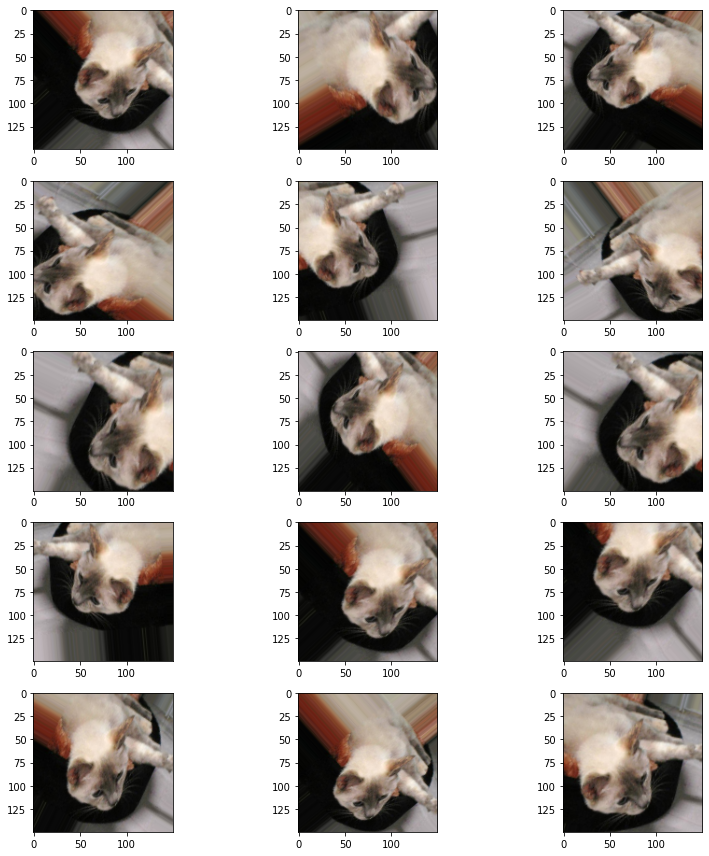

In [28]:
sample = random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_encoded[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 13. Model training

In [53]:
history = model.fit(train_generator, epochs=100,
                    callbacks=[callback_val_accuracy, callback_val_accuracy],
                    validation_data=validation_generator,
                    steps_per_epoch=100, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 51s 497ms/step - loss: 0.7273 - accuracy: 0.5112 - val_loss: 0.6624 - val_accuracy: 0.6110
Epoch 2/100
100/100 [==============================] - 46s 460ms/step - loss: 0.7104 - accuracy: 0.5290 - val_loss: 0.6400 - val_accuracy: 0.6600
Epoch 3/100
100/100 [==============================] - 46s 458ms/step - loss: 0.6899 - accuracy: 0.5550 - val_loss: 0.6193 - val_accuracy: 0.6920
Epoch 4/100
100/100 [==============================] - 46s 454ms/step - loss: 0.6711 - accuracy: 0.5882 - val_loss: 0.5946 - val_accuracy: 0.7550
Epoch 5/100
100/100 [==============================] - 45s 449ms/step - loss: 0.6537 - accuracy: 0.6178 - val_loss: 0.5697 - val_accuracy: 0.7790
Epoch 6/100
100/100 [==============================] - 45s 451ms/step - loss: 0.6351 - accuracy: 0.6402 - val_loss: 0.5416 - val_accuracy: 0.7990
Epoch 7/100
100/100 [==============================] - 45s 450ms/step - loss: 0.6180 - accuracy: 0.6630 - val_loss: 0.5138 -

## 14. Save the model

In [ ]:
model.save(path+"basic_model.h5")

## 15. Let's see the results

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
_, acc = model.evaluate(x_test_post_vgg16, y_test_encoded, verbose=0)
print('Test accuracy of the model without data augmentation -> %.3f' % (acc * 100.0))

## 16. Lets see some predictions

In [ ]:
predictions = model.predict(x_test_post_vgg16) 


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(1))
    plt.yticks([])

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color_plt = 'blue'
    else:
        color_plt = 'red'

    thisplot = plt.bar(range(1), np.max(predictions_array), color=color_plt)
    plt.ylim([0, 1])


We draw the first samples, with the predictions and their real values (a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red

In [ ]:
num_rows = 5
num_cols = 4
start = 490
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()